In [20]:
import gwpopulation
from gwpopulation.models.redshift import PowerLawRedshift
from bilby.core.result import read_in_result
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

In [21]:
gwpopulation.utils.get_version_information()

'0.6.3:'

In [22]:
np.__version__

'1.21.0'

## Loading in Hyperposterior samples from GWTC-3 data release PowerLawPlusPeak model

In [23]:
PP_path = '../GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json'
PP_result = read_in_result(PP_path)

In [24]:
print("run label: ", PP_result.label)

run label:  o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift


In [25]:
PP_hyperposterior_samples = PP_result.posterior.copy() # making a copy is best practice here so you don't accidentally modify things in-place
PP_hyperposterior_samples

,alpha,beta,mmax,mmin,lam,mpp,sigpp,delta_m,mu_chi,sigma_chi,...,lamb,amax,log_likelihood,log_prior,selection,pdet_n_effective,surveyed_hypervolume,log_10_rate,rate,min_event_n_effective
0,3.476035,1.192781,91.137635,3.335027,0.045152,32.019619,7.361617,5.502380,0.430299,0.037676,...,0.593878,1.0,86.219165,-20.158271,0.001980,5600.884717,1102.923927,1.539321,34.619495,184.210871
1,2.843807,0.551632,92.336309,3.455594,0.099132,21.146326,9.635711,3.504334,0.229716,0.027052,...,3.899003,1.0,88.795439,-20.158271,0.000176,7628.305892,24548.963167,1.203419,15.974191,91.831207
2,4.127894,1.910420,99.382743,4.114949,0.058528,26.304442,9.105968,4.430823,0.297703,0.036759,...,-0.096742,1.0,89.598445,-20.158271,0.002577,4734.966457,617.064144,1.681428,48.020645,94.982019
3,4.512565,1.291055,98.845047,2.963035,0.007879,32.267134,9.914114,9.800366,0.378698,0.052658,...,3.511903,1.0,90.035214,-20.158271,0.000295,5654.797132,16703.390755,1.146385,14.008291,289.936772
4,2.772482,0.149371,94.491001,5.138160,0.035747,30.469008,8.569162,3.361789,0.336149,0.034270,...,2.514446,1.0,90.339131,-20.158271,0.000582,8247.427572,6336.065138,1.302851,20.084052,261.964627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11179,3.388853,1.075150,89.768520,4.684262,0.030388,35.727936,3.478996,5.246642,0.244086,0.027675,...,2.733047,1.0,107.871029,-20.158271,0.000525,3796.539977,7811.787060,1.235183,17.186329,71.639539
11180,3.684463,1.539779,81.785901,5.327478,0.030328,34.102957,3.505780,5.133147,0.251205,0.033394,...,3.171738,1.0,107.877236,-20.158271,0.000377,4006.532961,11954.783380,1.175202,14.969305,72.109121
11181,3.684463,1.539779,81.785901,5.327478,0.030328,34.102957,3.505780,5.133147,0.251205,0.033394,...,3.171738,1.0,107.877236,-20.158271,0.000377,4006.532961,11954.783380,1.169904,14.787819,72.109121
11182,3.573136,0.627634,88.689645,5.303211,0.029184,34.600418,3.531467,4.342366,0.229689,0.032670,...,3.456785,1.0,107.909312,-20.158271,0.000266,3745.787380,15818.169705,1.239911,17.374440,73.194989


In [26]:
PP_hyperposterior_samples.keys()

Index(['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective'],
      dtype='object')

## Generating m_1 model from hyperposterior sample using two_componant_single function from gwpopulation - does not have smoothing

In [27]:
def gen_PLPP_model(mass, q, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """
    param_dict = {'mass_1':mass, 'mass_ratio':q}

    alpha = hyperpost_samp['alpha']
    beta = hyperpost_samp['beta']
    mmin = hyperpost_samp['mmin']
    mmax = hyperpost_samp['mmax']
    lam = hyperpost_samp['lam']
    mpp = hyperpost_samp['mpp']
    sigpp = hyperpost_samp['sigpp']
    break_fraction = hyperpost_samp['delta_m']

    return gwpopulation.models.mass.two_component_single(mass, alpha, mmin, mmax, lam, \
        mpp, sigpp)


In [28]:
masses= np.linspace(2.,100.)
qs= np.linspace(0.,1.)
PLPP = gen_PLPP_model(masses, qs, PP_hyperposterior_samples.iloc[7900])

/tmp/ipykernel_225674/3626844484.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-5,0)


(1e-05, 84.8104267973575)

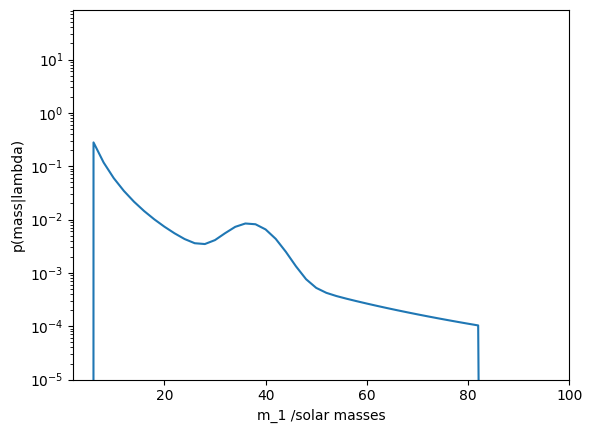

In [29]:
plt.plot(masses, PLPP)
plt.xlabel('m_1 /solar masses')
plt.ylabel('p(mass|lambda)')
plt.yscale('log')
plt.xlim(2,100)
plt.ylim(1e-5,0)

## Checking this gives the same as the SinglePeakSmoothedMassDistribution gwpopulation class - has smoothing

In [33]:
def gen_mass_model(mass, q, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """
    param_dict = {'mass_1':mass, 'mass_ratio':q}

    alpha = hyperpost_samp['alpha']
    beta = hyperpost_samp['beta']
    mmin = hyperpost_samp['mmin']
    mmax = hyperpost_samp['mmax']
    lam = hyperpost_samp['lam']
    mpp = hyperpost_samp['mpp']
    sigpp = hyperpost_samp['sigpp']
    break_fraction = hyperpost_samp['delta_m']

    mass_model = gwpopulation.models.mass.SinglePeakSmoothedMassDistribution()
    smoothing= mass_model.smoothing(mass, mmin=mmin, mmax=mmax, delta_m=break_fraction)

    return smoothing*mass_model.p_m1(param_dict, **{'alpha':alpha, 'mmin':mmin, 'mmax':mmax, 'lam':lam, \
        'mpp':mpp, 'sigpp':sigpp})


In [34]:
masses= np.linspace(2.,100.,1000)
qs= np.linspace(0.,1.,10000)
PLPP = gen_mass_model(masses, qs, PP_hyperposterior_samples.iloc[7900])

/tmp/ipykernel_156028/3626844484.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-5,0)


(1e-05, 3.0524740494922518)

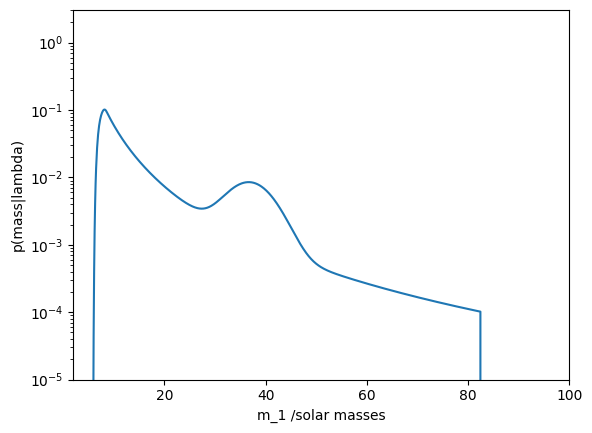

In [35]:
plt.plot(masses, PLPP)
plt.xlabel('m_1 /solar masses')
plt.ylabel('p(mass|lambda)')
plt.yscale('log')
plt.xlim(2,100)
plt.ylim(1e-5,0)

## Returning mass ratio distribution from SinglePeakSmoothedMassDistribution (broken?)

In [10]:
def gen_q_model(mass, q, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """
    param_dict = {'mass_1':mass, 'mass_ratio':q}

    beta = hyperpost_samp['beta']
    mmin = hyperpost_samp['mmin']
    break_fraction = hyperpost_samp['delta_m']

    q_model = gwpopulation.models.mass.SinglePeakSmoothedMassDistribution()

    return q_model.p_q(param_dict, beta, mmin, break_fraction)


In [17]:
masses= np.linspace(2.,100.,1000)
qs= np.linspace(0.,1.,1000)
PLQ = gen_q_model(masses, qs, PP_hyperposterior_samples.iloc[1])

(0.01, 10.0)

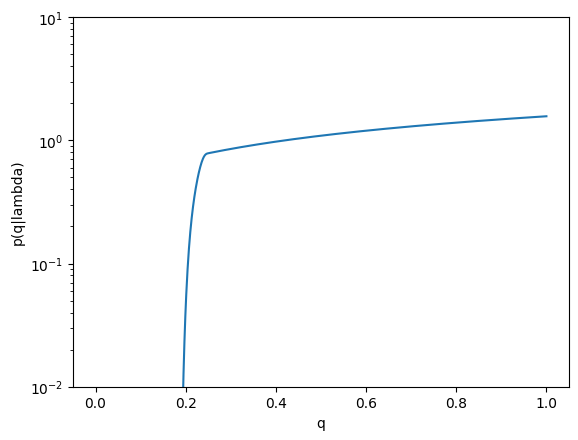

In [19]:
plt.plot(qs, PLQ)
plt.xlabel('q')
plt.ylabel('p(q|lambda)')
plt.yscale('log')
plt.ylim(1e-2,1e1)

## Generating redshift model from gwpopulation PowerLawRedshift

In [8]:
def gen_z_model(z, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """

    lamb = hyperpost_samp['lamb']
    param_dict = {'redshift':z}

    z_model = gwpopulation.models.redshift.PowerLawRedshift()

    return z_model.probability(param_dict, **{'lamb':lamb})

In [9]:
zs= np.linspace(0.,2.3,1000)
PLZ = gen_z_model(zs, PP_hyperposterior_samples.iloc[7900])

Text(0, 0.5, 'p(z|lambda)')

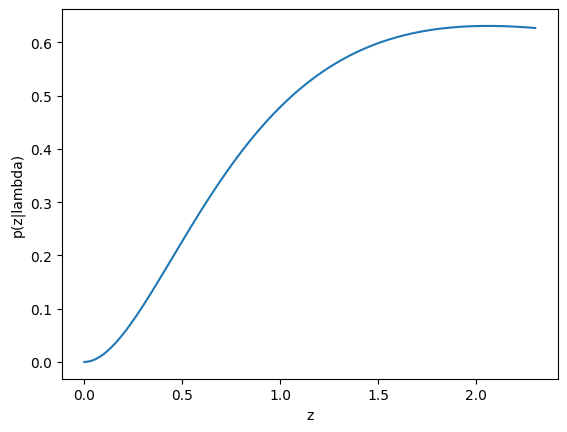

In [10]:
plt.plot(zs, PLZ)
plt.xlabel('z')
plt.ylabel('p(z|lambda)')
#plt.yscale('log')

## Generating spin models with iid_spin_magnitude_beta for spin magnitudes and iid_spin_orientation_gaussian_isotropic for spin tilts

In [39]:
def gen_spin_model(chi, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """

    amax = hyperpost_samp['amax']
    #notation is different in hyperposterior samples to gwpopulation/gwtc-3 pop paper:
    alpha_chi = hyperpost_samp['mu_chi']
    beta_chi = hyperpost_samp['sigma_chi']

    param_dict = {'a_1':chi, 'a_2':chi}


    return gwpopulation.models.spin.iid_spin_magnitude_beta(param_dict, amax=amax, alpha_chi=alpha_chi, beta_chi=beta_chi)

In [40]:
chis= np.linspace(0.,1.,1000)
IID_spinmag = gen_spin_model(chis, PP_hyperposterior_samples.iloc[7900])

Text(0, 0.5, 'p(chi_i|lambda)')

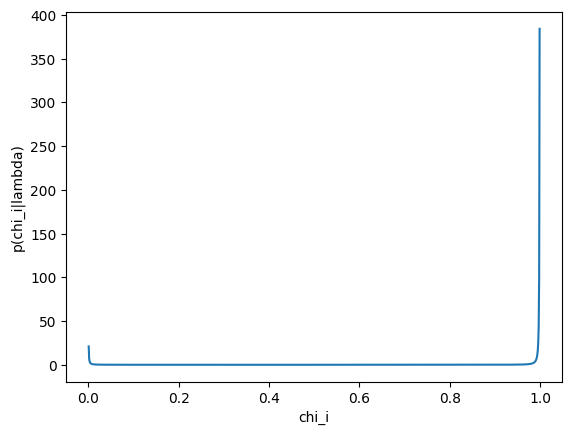

In [41]:
plt.plot(chis, IID_spinmag)
plt.xlabel('chi_i')
plt.ylabel('p(chi_i|lambda)')

In [32]:
def gen_spin_tilts(cos_tilt, hyperpost_samp):
    """
    Returns gwpopulation.models.mass.SinglePeakSmoothedMassDistribution from array of massesand  hyperposterior sample in 
    form of pandas data frame.
    Posterior samples should have keys:
    ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb', 'amax',
       'log_likelihood', 'log_prior', 'selection', 'pdet_n_effective',
       'surveyed_hypervolume', 'log_10_rate', 'rate', 'min_event_n_effective']
    """

    xi_spin = hyperpost_samp['xi_spin']
    sigma_spin = hyperpost_samp['sigma_spin']

    param_dict = {'cos_tilt_1':cos_tilt, 'cos_tilt_2':cos_tilt}


    return gwpopulation.models.spin.iid_spin_orientation_gaussian_isotropic(param_dict, xi_spin, sigma_spin)

In [34]:
tilts= np.linspace(-1.,1.,1000)
IID_spintilts = gen_spin_tilts(tilts, PP_hyperposterior_samples.iloc[7900])

Text(0, 0.5, 'p(cos tilt|lambda)')

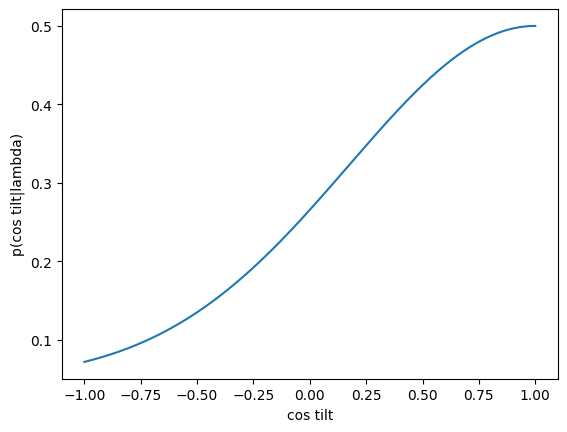

In [35]:
plt.plot(tilts, IID_spintilts)
plt.xlabel('cos tilt')
plt.ylabel('p(cos tilt|lambda)')